<a href="https://colab.research.google.com/github/danfolador/REDES/blob/main/REDES_Exercicio04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXERCÍCIO 04**

Aluno: Daniel Folador Rossi

Matrícula: 20201mpca0306

---

Nos vídeos, as arquiteturas e algoritmos foram testados, em geral, com resubstituição.

Verifique o desempenho da ELM criando um novo dataset, usando a mesma função de criação do dataset.




In [27]:
#======================================================
# INICIALIZAÇÃO
#======================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [28]:
#======================================================
# FUNCOES AUXILIARES
#======================================================
def PlotaRegiao(X, y, modelo, acuracia):
    
    
    h = 0.05
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))
    
    Xreg = np.c_[xx1.ravel(), xx2.ravel()]
    yreg = modelo.predict(Xreg)


    n_classes = len(set(y))
    levmin = min(set(y))-0.01
    levmax = max(set(y))+0.01

    levels=np.linspace(levmin,levmax,n_classes+1)
    cmap=plt.get_cmap('Paired')
    
    PlotaDataSet(X, y, transp=.2)
    plt.annotate('acuracia= ' + str(acuracia), xy=(0.05, 0.05), xycoords='axes fraction', color='red')
    plt.tricontourf(Xreg[:,0], Xreg[:,1], yreg, cmap=cmap, levels=levels, alpha=0.3)
    
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    
    return Xreg, yreg


def GeraDataSet_SepLin(tamanho=20, centros=4, random_state=None):
    X, y = make_blobs(n_samples=tamanho, centers=centros, center_box=(0,1.0), cluster_std=0.1, random_state=random_state)
    return X, y

def GeraDataSet_NaoSepLin(tamanho=20, centros=[[0,0],[1,0],[1,1],[0,1]], random_state=None):
    X, y = make_blobs(n_samples=tamanho, centers=centros, cluster_std=0.05, random_state=random_state)
    y = np.array(y%2, dtype=int)
    return X, y

def PlotaDataSet(X, y, transp):
    
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    #plota pra cada classe
    for k in set(y):
        logic = y==k
        plt.plot(X[:,0][logic], X[:,1][logic], 'o', alpha=transp)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)

def CriaCategoricos(y):
    replacements = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
    replacer = replacements.get
    y = [replacer(n, n) for n in y]
    return y

def TrataRotulos(y):
    # Substitui por rótulos numéricos
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    
    # Para o caso binário, substitui por -1/+1
    if len(set(y))<=2: y = y*2-1
    return y


In [29]:
#======================================================
# ALGORITMOS
#======================================================

# PSEUDO-INVERSA
#--------------------------------------------------
class PseudoInversa():
    def __init__(self):
        pass
    def getw(self, X, y):
        w = np.random.uniform(-1, 1,size=(X.shape[1], y.shape[1]))
        pinv = np.linalg.pinv(X)
        w = np.matmul(pinv, y)
        return w

In [30]:
#======================================================
# ELM
#======================================================
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit


def tanh(a):
    return expit(a)*2-1

class ExtremeLearningMachine(BaseEstimator, ClassifierMixin):
    
    # INIT
    #--------------------------------------------------
    def __init__(self, algoritmo=PseudoInversa(), threshold=0):
        self.wih = None
        self.w = None
        self.threshold = threshold
        #self.activation = lambda a: (a>=0)*2 -1
        self.activation = tanh
        self.algoritmo = algoritmo
    
    # BIAS
    #--------------------------------------------------
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    # FIT
    #--------------------------------------------------        
    def fit(self,X,y):
        
        #Pesos de input da camada hidden
        #vamos usar k vezes o número de características de X
        k = 3
        self.wih = np.random.uniform(size=(X.shape[1], X.shape[1]*k))
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        X = ExtremeLearningMachine.includebias(Xho)
        
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        
        # Treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getw(X, y, self.activation)    
        else:
            self.w = self.algoritmo.getw(X, y)


    # PREDICT
    #--------------------------------------------------     
    def predict(self,X):
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)       
        Xb = ExtremeLearningMachine.includebias(Xho)  #Vamos usar o bias apenas na camada de saída
        a = np.matmul(Xb, self.w)
            
        #Caso binário
        if self.w.shape[1]<=1:
            logic = self.activation(a) > self.threshold
            idx = np.array(logic, dtype=int)[:,0]
        #Caso multiclasse
        else:
            idx = np.argmax(a, axis=1)
        
        ypred = np.array([self.labels[i] for i in idx])     

        return ypred

In [31]:
#======================================================
# FUNCAO AJUSTE
#======================================================
def Ajuste(Xtrain, Xtest, ytrain, ytest, modelo, plota_vetor):

    # AJUSTE
    #------------------------------------------------------      
    modelo.fit(Xtrain, ytrain)
    ypred = modelo.predict(Xtest)             #Prediçao com resubstituição
    acuracia = sum(ytest==ypred)/len(ytest)

    # Caso Binário
    if len(set(ytest))<=2:
        pesos = modelo.w[1:]
        bias = modelo.w[0]
       
    # Caso Multiclasse
    else:
        for i in range(len(set(ytest))):
            pesos = modelo.w[1:,i]
            bias = modelo.w[0,i]

    pesos = modelo.w[1:]
    bias = modelo.w[0]

    
    return pesos, bias, acuracia

In [32]:
#======================================================
# BANCO DE DADOS
#======================================================   
# Gera dados
n_classes = 4
lin_sep = 1
datasets=[]

#Linearmente Separados
for _ in range(2):
    X, y = GeraDataSet_SepLin(200, centros=n_classes)
    y = CriaCategoricos(y)
    datasets.append((X,y))
    
    df1 = pd.DataFrame(X, columns=['X1','X2'])
    df2 = pd.DataFrame(y, columns=['y'])
    df = pd.concat([df1, df2],axis=1)
    print(df.head(10))
    print()

#Não-Linearmente Separados
for _ in range(2):
    X, y = GeraDataSet_NaoSepLin(200, centros=n_classes)   
    y = CriaCategoricos(y)
    datasets.append((X,y))
    
    df1 = pd.DataFrame(X, columns=['X1','X2'])
    df2 = pd.DataFrame(y, columns=['y'])
    df = pd.concat([df1, df2],axis=1)
    print(df.head(10))
    print()

         X1        X2  y
0  0.809525  0.277333  a
1  1.091169  0.096242  a
2  0.850142  1.000222  c
3  0.637298  0.957049  c
4  0.706278  0.884123  c
5  0.208404  0.089681  d
6  1.121857  0.144291  a
7  0.922155  0.092983  a
8  0.590485  0.485006  b
9  0.361884  0.488395  b

         X1        X2  y
0  0.868938  0.576599  a
1  0.597634  1.148775  c
2  0.940646  0.595217  a
3  1.009160  0.490927  d
4  0.958980  0.739161  a
5  1.054021  0.567942  d
6  0.745910  0.562028  d
7  0.517448  0.914269  c
8  0.868158  0.714828  a
9  0.723041  0.714207  c

         X1        X2  y
0 -8.710813  6.898360  a
1  2.611877 -5.525769  b
2  7.892410 -3.487342  a
3 -8.640312  6.982309  a
4  2.614700 -5.496600  b
5  7.406085  7.195885  b
6  2.482494 -5.385897  b
7  7.873159 -3.427257  a
8 -8.764965  6.942316  a
9 -8.713107  6.896394  a

         X1         X2  y
0 -6.494446  -9.964975  a
1  3.285075  -2.321722  a
2  3.163101  -2.340220  a
3 -6.513768 -10.004727  a
4  8.487827  -6.934258  b
5 -6.449536  -9.

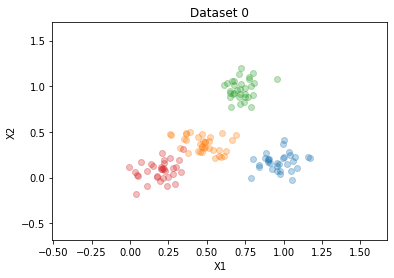

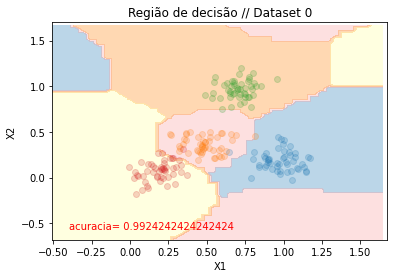


Resultados
--------------------------------------------
bias= [-1.19085973 -1.40248914 -1.01703728  1.61038615]
pesos= [[ -1332.77346588   2235.43726592   -485.4711451    -417.19265495]
 [   193.69876495   -288.47436999    179.54053388    -84.76492884]
 [  7342.78052671 -11791.3004561    2327.52270346   2120.99722594]
 [  -156.62462269    261.20945351   -152.58893362     48.00410281]
 [  9188.00184922 -15020.20861477   3182.10815077   2650.09861478]
 [-13708.29690562  22098.56633703  -4603.51093891  -3786.75849249]]
acuracia= 0.9924242424242424



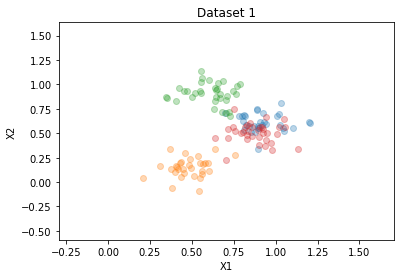

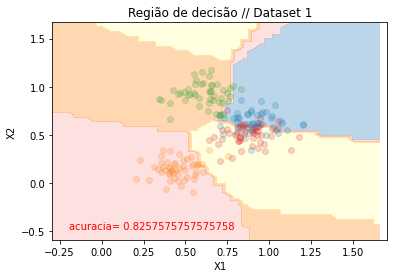


Resultados
--------------------------------------------
bias= [-1.00836663  3.05350677 -0.96757951 -3.07756064]
pesos= [[  4122.39425638  -1936.01737682   9257.24055137 -11443.61743092]
 [  4384.36661978  -1449.03163583   7156.85093095 -10092.18591489]
 [ -6080.87125504   2675.3010028  -12406.777569    15812.34782125]
 [  1518.61091758  -1445.98888964   6392.11439499  -6464.73642293]
 [   109.28137907     57.99359961   -305.32972186    138.05474318]
 [ -3213.48045719   1923.79849076  -9077.50750625  10367.18947268]]
acuracia= 0.8257575757575758



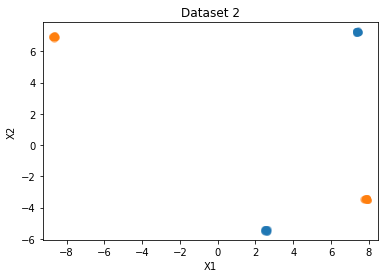

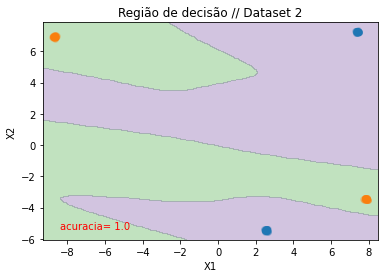


Resultados
--------------------------------------------
bias= [-0.09100426]
pesos= [[  1.53857021]
 [ -0.17057822]
 [ 40.9981315 ]
 [ -7.8915714 ]
 [ -1.71540569]
 [-35.16710702]]
acuracia= 1.0



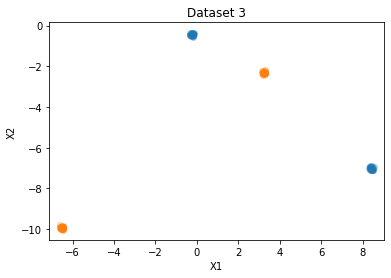

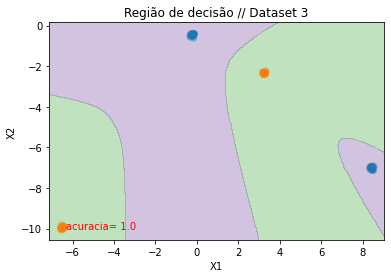


Resultados
--------------------------------------------
bias= [-0.99193041]
pesos= [[-10.322471  ]
 [ 41.92099255]
 [ 13.82561975]
 [ -2.86049756]
 [-19.66304799]
 [-25.03445011]]
acuracia= 1.0



In [33]:
#======================================================
# RODADAS
#======================================================
threshold = 0
modelo = ExtremeLearningMachine(PseudoInversa(),threshold)

i=0
for ds in datasets:
    
    X, y = ds
    y=TrataRotulos(y)

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.66)
    
    plt.title('Extreme Learning Machine')
    PlotaDataSet(Xtest, ytest, transp=0.3)

    ds_name = 'Dataset ' + str(i)
    
    plt.title(ds_name)
    pesos, bias, acuracia = Ajuste(Xtrain, Xtest, ytrain, ytest, modelo, plota_vetor=False)
    plt.show()
    
    plt.title('Região de decisão // ' + ds_name)
    PlotaRegiao(X, y, modelo, acuracia)
    plt.show()
    i+=1

    print()
    print('Resultados')
    print('--------------------------------------------')
    print('bias=', bias)
    print('pesos=', pesos)
    print('acuracia=', acuracia)
    print()


